<a href="https://colab.research.google.com/github/OlaKlingberg/Disaster-Tweet-Classifier/blob/main/Disaster_Tweet_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Natural Language Processing with Disaster Tweets**

This notebook pertains to the Kaggle getting-started competition [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started). The task is to build a machine-learning model that can classify tweets based on whether they are related to disasters or not.

I will build and compare three different architectures of an LSTM (Long Short-Term Memory) model, using GloVe embeddings, and one DistilBert model.
* The LSTM model is a type of Recurrent Neural Network (RNN) that processes the text sequentially, which means that the word order will affect the classification.
* DistilBert is a transformer-based model. It processes the words of the text in parallel, which can make it better at taking the full context into consideration.

I chose LSTM and DistilBert since they are often used for text classification.

I will fit each model a number of times, with different hyper-parameter, and then select the best-performing version.

This notebook is available at [github/OlaKlingberg/DTSA-5511-M4-Disaster-Tweet-Classifier](https://github.com/OlaKlingberg/DTSA-5511-M4-Disaster-Tweet-Classifier/blob/main/DTSA_5511_M4_Disaster_Tweet_Classifier.ipynb)


# **Data**

The data consists of a training set and a testing set.

The training set contains 7,613 tweets with columns for id, keyword, location, text (the tweet itself) and target (the class label: 1 for tweets related to disasters, and 0 for those that are not).

The test set contains 3,263 tweets with the same columns, except the target column.

In this project, I will base the classification only on the text column (the tweet text), though it might also have been worthwhile to include the location and especially the keyword column in the analysis.



# **Imports**

In [1]:
!pip install -q keras-core --upgrade
!pip install -q keras-nlp --upgrade
!pip install -q tensorflow-text

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 691.2/691.2 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 94.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [2]:
# This sample uses Keras Core, the multi-backend version of Keras.
# The selected backend is TensorFlow (other supported backends are 'jax' and 'torch')
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [3]:
!pip install -q --upgrade keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [4]:
import numpy as np
import pandas as pd
import os
from datetime import datetime
import pytz
import json

import seaborn as sns

import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, train_test_split

from sklearn.utils import compute_class_weight

import seaborn as sns
import matplotlib.pyplot as plt

from keras_nlp.models import DistilBertPreprocessor
from keras_nlp.models import DistilBertClassifier

from tensorflow.keras import backend as K

from tensorflow.keras.callbacks import EarlyStopping, Callback

from tensorflow.keras.layers import Input

# from tensorflow.keras.metrics import Precision, Recall

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional


Using TensorFlow backend


In [5]:
print(tf.__version__)
print(keras.__version__)
print(keras_nlp.__version__)

2.18.0
0.1.7
0.18.1


# **Load the data**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
main_dir = '/content'
data_dir = os.path.join(main_dir, 'data')
results_dir = os.path.join(main_dir, 'results')

df_train = pd.read_csv(os.path.join(data_dir, "train.csv"))
df_test = pd.read_csv(os.path.join(data_dir, "test.csv"))

# **Exploratory Data Analysis**

## Take a look at the data sets

In [8]:
display(df_train.head())
print(df_train.shape)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


(7613, 5)


In [9]:
display(df_test.head())
print(df_test.shape)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


(3263, 4)


In [10]:
# Confirm that the target column only contains the values 0 and 1.
df_train['target'].unique()

array([1, 0])

## Deal with duplicates

Let's check if the training set contains any duplicate tweets.

In [11]:
# Display any duplicate rows based on the 'text' column
duplicates = df_train[df_train['text'].duplicated()]

# Print a few duplicates
print(duplicates[['text', 'target']].sort_values(by = 'text').head())

# Total number of duplicates
print(f"\nThe training data has {len(duplicates)} tweets that are not unique.")

                                                   text  target
4299  #Allah describes piling up #wealth thinking it...       0
4312  #Allah describes piling up #wealth thinking it...       1
6366  #Bestnaijamade: 16yr old PKK suicide bomber wh...       1
6373  #Bestnaijamade: 16yr old PKK suicide bomber wh...       1
6392  #Bestnaijamade: 16yr old PKK suicide bomber wh...       1

The training data has 110 tweets that are not unique.


From the above, we can draw two conclusions:
* There are duplicate tweets with conflicting labels.
* There are tweets with more than two duplicates.

Let's take a closer look at duplicates with conflicting labels.




In [12]:
# Find duplicate tweets with different labels
conflicting_duplicates = df_train.groupby('text')['target'].nunique().reset_index()
conflicting_duplicates = conflicting_duplicates[conflicting_duplicates['target'] > 1]

# Display the texts with conflicting labels
print(conflicting_duplicates['text'])

# How many
print(f"\nThere are {len(conflicting_duplicates)} unique texts that have different labels.")

24      #Allah describes piling up #wealth thinking it...
284     #foodscare #offers2go #NestleIndia slips into ...
610     .POTUS #StrategicPatience is a strategy for #G...
2679    CLEARED:incident with injury:I-495  inner loop...
2748    Caution: breathing may be hazardous to your he...
3589    He came to a land which was engulfed in tribal...
3616    Hellfire is surrounded by desires so be carefu...
3618    Hellfire! We donÛªt even want to think about ...
3750    I Pledge Allegiance To The P.O.P.E. And The Bu...
4193    In #islam saving a person is equal in reward t...
4708    Mmmmmm I'm burning.... I'm burning buildings I...
5367    RT NotExplained: The only known image of infam...
6131    The Prophet (peace be upon him) said 'Save you...
6353                           To fight bioterrorism sir.
6825    Who is bringing the tornadoes and floods. Who ...
7265    like for the music video I want some real acti...
7372    that horrible sinking feeling when youÛªve be...
7449    wowo--

The duplicate tweets with conflicting labels constitute a kind of noise. Including them in the training data would likely make our model perform worse.

The best way of handling the duplicates with conflicting labels would probbly be to go through them and manually remove the ones that we deem to be incorrectly labeled. But here I will use the simpler solution of just removing *all* duplicates with conflicting labels.

In [13]:
# Identify duplicates with conflicting labels
conflicting_texts = df_train.groupby('text')['target'].transform('nunique') > 1

# Filter out rows where the text has conflicting labels
df_cleaned = df_train[~conflicting_texts]

# Reset the index
df_cleaned = df_cleaned.reset_index(drop = True)

print(f"Number of tweets BEFORE removing duplicates with conflicting labesl:", len(df_train))
print(f"Number of tweets AFTER removing duplicates with conflicting labesl:", len(df_cleaned))


Number of tweets BEFORE removing duplicates with conflicting labesl: 7613
Number of tweets AFTER removing duplicates with conflicting labesl: 7558


There may still be duplicates that don't have conflicting labels. Let's check.

In [14]:
# Display any duplicate rows based on the 'text' column
duplicates = df_cleaned[df_cleaned['text'].duplicated()]

# Print the duplicates
print(duplicates[['text', 'target']])

# Total number of duplicates
print(f"There are now {len(duplicates)} tweets that are not unique.")

                                                   text  target
48    Check these out: http://t.co/rOI2NSmEJJ http:/...       0
115   320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...       0
119   320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...       0
164   Experts in France begin examining airplane deb...       1
1152  Japan on Thursday marks the 70th anniversary o...       1
...                                                 ...     ...
7545  Evacuation order lifted for town of Roosevelt:...       1
7552  #stormchase Violent Record Breaking EF-5 El Re...       1
7554  @aria_ahrary @TheTawniest The out of control w...       1
7555  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1
7556  Police investigating after an e-bike collided ...       1

[73 rows x 2 columns]
There are now 73 tweets that are not unique.


Keeping the duplicates would give extra weight to these tweets. I don't see any reason why these tweets should be given extra weight, so I will keep just one instance of every duplicated tweet.

In [15]:
# Of these remaining dupes (which have non-conflicting labels), we'll keep one of each.
df_unique = df_cleaned.drop_duplicates(subset = 'text', keep = 'first')

print(len(df_train))
print(len(df_unique))

7613
7485


In [16]:
# We'll finish by assigning df_unique back to df_train
df_train = df_unique.reset_index(drop = True)

## Take a look at a few tweets of each class

I will now take a look at twenty randomly chosen tweets from each class.

In [17]:
print("Class 0: not related to disasters")

for _, tweet in df_train[df_train['target'] == 0][['id', 'target', 'text']].sample(n = 20, random_state = 42).iterrows():
    print(tweet['id'], tweet['text'])

Class 0: not related to disasters
4445 THE LINKS TO WATCH THE SHOW BETTER WORK OR I MIGHT ELECTROCUTE SOMEONE
6808 tarmineta3: Breaking news! Unconfirmed! I just heard a loud bang nearby. in what appears to be a blast of wind from my neighbour's ass.
4710 [Question] Is anybody else having this problem with the '7' circle in Epicentre? via /r/jailbreak http://t.co/48TPnmbJVG
5609 12' 72W CREE LED Work Light Bar Alloy Spot Flood Combo Diving Offroad 4WD Boat - Full readÛ_ http://t.co/MJMwA72ER6 http://t.co/ADx9iYi246
8947 omfg.... I just woke up again....
6572 #Cowboys: Wednesday's injury report: RB Lance Dunbar injures ankle is listed as day-to-day:  http://t.co/RkB7EgKveb
4256 Why are you drowning in low self-image? Take the quiz: http://t.co/Z8R6r3nBTb http://t.co/nAmffldh5h
3217 Also in a matter of weeks Amazon's going to be deluged with poorly written indie dystopian fiction about teens escaping from blood farms.
6532 4 Common Running Injuries and How to Avoid Them http://t.co/E5cN

In [18]:
print("Class 1: related to disasters")

for _, tweet in df_train[df_train['target'] == 1][['id', 'text', 'target']].sample(n = 20, random_state = 42).iterrows():
    print(tweet['id'], tweet['text'])

Class 1: related to disasters
3955 70 Years After Atomic Bombs Japan Still Struggles With War Past: The anniversary of the devastation wrought b... http://t.co/ohNdh2rI0V
3877 Don't miss Chris #Appy's detonation of the myths obscuring our crime in #Hiroshima 70 yrs ago this month. @salon http://t.co/DlP8kPkt2k
3072 [Comment] Deaths of older children: what do the data tell #US? http://t.co/p8Yr2po6Jn
 #nghlth
1759 Sinking ships burning buildings &amp; Falling objects are what reminds me of the old us.
4132 For these Californians it's like living in Africa's Sahel desert - just finding water a daily chore. http://t.co/ySG9vsrT4g
2399 @xDescry I was wrong to call it trusty actually.. considering it spontaneously collapsed on me that's not very trusty.
2396 @flickershowell oh wow my heart collapsed cool im crying cool cool
5336 This fire is WAY too close wtf is going on ???? http://t.co/drf3mmRbyx
478 @Erker Again?? Eep! Thought of you yesterday when I saw that hella scary hail. #armageddo

This led to two important insights.

First, many tweets are like a single sentence taken out of a conversation: hard to interpret without a context. This poses a  problem for the task of classifying them. Ideally, for each tweet, we should check if it was part of a thread, or a response to some other tweet, and then somehow include that context in our classification. But that would require data not included in the given data set, so I won't do that here.

Secondly, even more importantly, the labeling of the tweets seems to be quite unreliable. Let's divide the Class 1 tweets into three groups:
* Group 1. Correctly labeled. Contains something that can be interpreted as a reference to a disater.
* Group 2. Unclear. So hard to interpret without a context that you can't really determine if they are about disasters or not.
* Group 3. Incorrectly labeled. The meaning seems clear enough, and it does not have anything to do with disasters.

### Group 1. Correctly labeled. 12 tweets (60%)
* For these Californians it's like living in Africa's Sahel desert - just finding water a daily chore. http://t.co/ySG9vsrT4g
* 4678 #RaheelSharif is manifesting how one RIGHT man at the helm can save a Sinking Ship engulfed in a Dark-Stormy-Tidal-Sea. Well Done.
* 5336 This fire is WAY too close wtf is going on ???? http://t.co/drf3mmRbyx
* 478 @Erker Again?? Eep! Thought of you yesterday when I saw that hella scary hail. #armageddon?
* 4333 Raw Video: Dust Storm Rolls Through Texas http://t.co/QllkOfdyzX http://t.co/rGjJuMnNah
* 70 Years After Atomic Bombs Japan Still Struggles With War Past: The anniversary of the devastation wrought b... http://t.co/ohNdh2rI0V
* Don't miss Chris #Appy's detonation of the myths obscuring our crime in #Hiroshima 70 yrs ago this month. @salon http://t.co/DlP8kPkt2k
* Sinking ships burning buildings &amp; Falling objects are what reminds me of the old us.
* 10770 #science Now that a piece of wreckage from flight MH370 has been confirmed on RÌ©union Island is it possible t...  http://t.co/Z2vDGIyOwf
* 1675 Sioux City Fire Officials Believe Bridge Collapse Lead To Cement Truck Roll Over - Siouxland Matters: Siouxlan... http://t.co/sZTGmbkoHG
* 5187 OSP concerned about mounting fatalities http://t.co/YmP0gInwza http://t.co/FYIOQvIOif
* 1961 dog rendered a kitten from burning buildings

### Group 2. Unclear. 7 tweets (35%)
These tweets are hard to interpret without context:
* @xDescry I was wrong to call it trusty actually.. considering it spontaneously collapsed on me that's not very trusty.
* 2929 @bluebirddenver #FETTILOOTCH IS #SLANGLUCCI OPPRESSIONS GREATEST DANGER COMING SOON THE ALBUM
* @flickershowell oh wow my heart collapsed cool im crying cool cool
* You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

While these tweets refer to horrific events, it's doubtful if they belong to what people typically think of as "disasters."
* Islamic State group in Egypt threatens to kill Croat hostage http://t.co/eIoQJWgEiX
* Oops: Bounty hunters try to raid Phoenix police chief's home: A group of armed bounty hunters surrounded the h... http://t.co/dGELJ8rYt9
* [Comment] Deaths of older children: what do the data tell #US? http://t.co/p8Yr2po6Jn

### Group 3. Incorrectly labeled. 1 tweet (5%)
This tweets is quite clear, and does not refer to a disaster:
* \#hot  C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/OnvD9D4NKg #prebreak #best

### Conclusion
The result is somewhat disheartening. Out of our 20 randomly sampled tweets, only 12 (60%) are clearly correctly labeled. One tweet (5%) is clearly incorrectly labeled, and for a whopping 7 tweets (35%), it's unclear if they should be considered to be about disasters.

The best thing to do would probably be to manually go through the entire training set and relable all the tweets. But that kind of work would seem to go beyond the scope of this school project. I will simply use the labels we have, in spite of their unreliability.






## Check the length distribution of tweets

Below, we can see that the tweets in the training set are between 7 and 157 characters long, with a mean of 101 characters.

The tweets in a test set have a similar distribution: they are between 5 and 151 characters long, with a mean of 102 characters.

In [19]:
# Text length distribution in training and testing set.
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7485.000000
mean      100.880428
std        33.826640
min         7.000000
25%        77.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


## Check class distribution

The classes are not perfectly balanced. We will handle this imbalance by assigning different weights to the two classes.

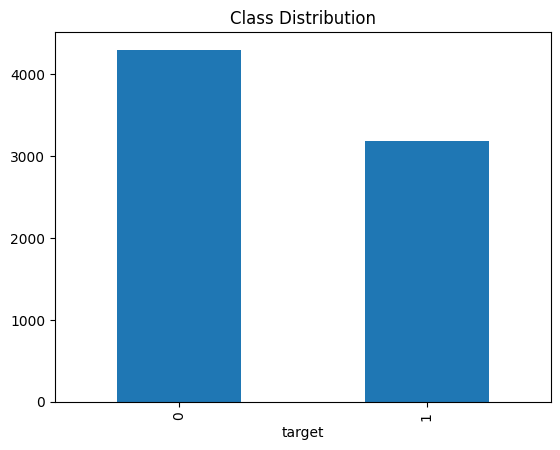

In [20]:

df_train.target.value_counts().plot(kind = 'bar')
plt.title("Class Distribution")
plt.show()

In [21]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes = np.array([0, 1]), y = df_train['target'])

class_weights

array([0.87095648, 1.1739335 ])

# **Configuration: model selection and hyper-parameter values**



In [22]:
# Configs
config = {
    'remove_urls': False,
    'remove_mentions': True,
    'remove_hashtags': False,
    'remove_non_alphas': False,         # Remove all non-alpha characters.
    'model': 'distilbert',              # 'lstm' or 'distilbert'
    'max_vocab_size': 10000,            # Only for model = 'lstm':
    'max_sequence_length': 100,         # Only for model = 'lstm':
    'embedding_dim': 100,               # Only for model = 'lstm':
    'architecture': 'bidirectional',    # Only for model = 'lstm': 'one_layer', 'two_layer', or 'bidirectional'
    'first_lstm_layer': 32,             # Only for model = 'lstm': Number of units in the first LSTM layer
    'second_lstm_layer': 64,            # Only for model = 'lstm': Number of units in the second LSTM layer
    'dropout': 0.4,                     # Dropout rate to overfitting
    'lr': 0.00001,                        # Learning rate
    'class_0_weight': class_weights[0], # Balanced: class_weights[0]
    'class_1_weight': class_weights[1], # Balanced: class_weights[1]
    'batch': 128,                       # Batch size
    'epochs': 15,                       # Number of epochs
    'patience': 3,                      # Early-stopping patience

}

## The configuration dictionary
I will use the dictionary above to select which model to build and which values to use for all hyper-parameters I intend to tune. Towards the end of the notebook, I will save this dictionary to disk, along with the performance metrics for that model. This will give us a record of all the model builds I have tried.

## Configuration values to explore
As mentioned before, I will explore two different kinds of models: LSTM and DistilBert. For the LSTM model, I will try three different architectures:
* with one LSTM layer,
* with two LSTM layers,
* with one bidirectional LSTM layer.

For each of these models, there are several hyper-parameter to test. Even limiting ourselves to a small number of values for each hyper-parameter, we'll get quite a large hyper-parameter space to explore. Here is a calculation of the number of possible combintions.

**Cleaning**
* Remove Urls: True, False
* Remove Mentions: True, False
* Remove Hashtags: True, False
* Remove all alpha characters: True, False

Cleaning combinations: $2 \times 2 \times 2 \times 2 = 16$

**LSTM model with one layer**
* First LSTM layer, number of units: 32, 64, 128
* Dropout rate: 0.2, 0.3, 0.4, 0.5, 0.6
* Learning rate: 0.01, 0.001, 0.0001
* Class 0 weight: balanced, 0.8, 0.75 (Determined during early testing.)
* Class 1 weight: Only 1 option for each Class 0 weight
* Batch size: 16, 32, 64, 128

One-layer LSTM combinations: $3 \times 5 \times 3 \times 3 \times 4 = 540$

**LSTM model with two layers**

Same as LSTM model with one layer, plus the options for the second layer:
* Second LSTM layer, number of units: 32, 64, 128.

Two-layer LSTM combinations: $540 \times 3 = 1,620$

**LSTM model with bidirectional layer**

Same as LSTM model with one layer.

Bidirectional LSTM combinations: $540$

**DistilBert model**
* Learning Rate: 0.00001, 0.00003, 0.00005
* Class 0 weight: balanced, 0.8, 0.75 (Determined during early testing.)
* Class 1 weights: Only 1 option for each Class 0 weight.
* Batch size: 16, 32, 64, 128

DistilBert model combinations: $3 \times 3 \times 4 = 36$

**Total number of configurations**

For the four different models (one-layer LSTM, two-laywer LSTM, bidirectional LSTM, DistilBert) we have a total of $540 + 1,620 + 540 + 36 = 2,736$ combinations.

Each of those combinations can be tried with each of the 16 cleaning combinations, for a total configuration space of $2,736 \times 16 = 43,776$ combinations.

It should go without saying that I will only be able to explore a tiny fraction of that space.

**Strategy**

I will follow this strategy:
1. Using an LSTM model with reasonable settings, try the cleaning options one by one, separately, and then combine the most promising ones, and then stick with that cleaning.
2. Explore the LSTM one-layer model by tweaking one parameter at the time.
3. Explore the LSTM two-layer model, using the best parameter settings from the one-layer model as a starting point, tweaing one parameter at the time.
4. Explore the LSTM bidirectional model, using the best parameter settings from the one- and two-layer models as starting point, tweaking one parameter at the time.
5. Explore the DisitilBert model by tweaking one parameter at the time.

I will generate a graph showing how the metrics change over the course of the epochs and use that as a guidance when deciding which parameter to tweak next and how to tweak it. (This will involve a lot of trail-and-error.)

To limit training time, I will use K-fold cross-validation with only 3 folds. This is a compromise between running it with the typical 5 or 10 folds, which would yield more stable results but take longer, and not running K-folds cross-validation at all, but just use a dedicated validation set, which would be faster but yield more volatile results.



# **Data cleaning**

In [23]:
# Remove URLs
if config['remove_urls']:
    df_train['text'] = df_train['text'].str.replace(r'http\S+|www\S+|https\S+', '', regex=True)

In [24]:
# Remove mentions
if config['remove_mentions']:
    df_train['text'] = df_train['text'].str.replace(r'@\w+', '', regex=True)

In [25]:
# Remove hashtags
if config['remove_hashtags']:
    df_train['text'] = df_train['text'].str.replace(r'#\w+', '', regex=True)

In [26]:
# Remove all non-alpha characters
if config['remove_non_alphas']:
    df_train['text'] = df_train['text'].str.replace(r'[^a-zA-Z\s]', '', regex = True).str.lower()

# **GloVe embeddings**

For the LSTM models, I will use GloVe embeddings.

In [27]:
# Load GloVe embeddings
embedding_index = {}
with open(os.path.join(data_dir, 'glove.6B.100d.txt'), encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print(f'Found {len(embedding_index)} word vectors.')

Found 76916 word vectors.


In [28]:
X_train_df = df_train["text"]
y_train_df = df_train["target"]

X_test_df = df_test["text"]

# Prepare the tweets
# texts = df_train['text']
max_vocab_size = 10000  # Limit vocab size to top 10,000 words
max_sequence_length = 100  # Max length of each tweet (in tokens)

# Tokenize the text data
tokenizer = Tokenizer(num_words = max_vocab_size)
tokenizer.fit_on_texts(X_train_df)
word_index = tokenizer.word_index

# Convert text to sequences of integers and pad
X_train_sequences = tokenizer.texts_to_sequences(X_train_df)
X_train_padded = pad_sequences(X_train_sequences, maxlen = max_sequence_length)

X_test_sequences = tokenizer.texts_to_sequences(X_test_df)
X_test_padded = pad_sequences(X_test_sequences, maxlen = max_sequence_length)

# Prepare the embedding matrix
embedding_dim = 100  # Using 100-dimensional GloVe vectors
embedding_matrix = np.zeros((max_vocab_size, embedding_dim))

for word, i in word_index.items():
    if i < max_vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding_index will be all-zeros
            embedding_matrix[i] = embedding_vector

# Sanity check: check that the training data and the training labels have the same length.
print(X_train_df.shape)
print(y_train_df.shape)

(7485,)
(7485,)


# **Models**

In [29]:
# Function to build the LSTM model
def build_lstm_model(config, embedding_matrix):
    """
    Builds an LSTM model based on the given configuration and embedding matrix.

    Args:
        config (dict): Configuration dictionary containing the following keys:
            - 'architecture' (str): The type of LSTM architecture ('one_layer', 'two_layer', or 'bidirectional').
            - 'first_lstm_layer' (int): Number of units for the first LSTM layer.
            - 'second_lstm_layer' (int): Number of units for the second LSTM layer (only for 'two_layer' architecture).
            - 'dropout' (float): Dropout rate for regularization.
        embedding_matrix (numpy.ndarray): Pre-trained embedding matrix to initialize the embedding layer.

    Returns:
        keras.models.Sequential: The compiled LSTM model.
    """
    model = Sequential()

    # Add the Input layer separately
    model.add(Input(shape=(max_sequence_length,)))

    # Add the embedding layer
    model.add(Embedding(input_dim = max_vocab_size,
                        output_dim = embedding_dim,
                        weights = [embedding_matrix],
                        trainable = False))  # Set trainable=False to use pretrained embeddings

    # Add layers based on selected model architecture
    if config['architecture'] == 'one_layer':
        model.add(LSTM(config['first_lstm_layer'], return_sequences=False))  # Single LSTM layer
    elif config['architecture'] == 'two_layer':
        model.add(LSTM(config['first_lstm_layer'], return_sequences=True))  # First LSTM layer returns full sequence
        model.add(LSTM(config['second_lstm_layer'], return_sequences=False))  # Second LSTM layer
    elif config['architecture'] == 'bidirectional':
        model.add(Bidirectional(LSTM(config['first_lstm_layer'])))  # Bidirectional LSTM
    else:
        raise ValueError("Invalid architecture. Choose from 'one_layer', 'two_layer', or 'bidirectional'.")

    # Add the dropout and activation layers.
    model.add(Dropout(config['dropout'])) # Add a Dropout layer for regularization
    model.add(Dense(1, activation='sigmoid'))  # Use 'sigmoid' for binary classification

    return model

In [30]:
# Function to build the DistilBert model
def build_distilbert_model(config):
    """
    Builds a DistilBERT-based model for text classification.

    Args:
        config (dict): Configuration dictionary containing settings for the model.

    Returns:
        keras.Model: A pre-trained DistilBERT classifier model configured for binary classification.
    """
    AUTO = tf.data.experimental.AUTOTUNE

    # Load a DistilBERT model.
    preset= "distil_bert_base_en_uncased"

    # Use a shorter sequence length.
    preprocessor = DistilBertPreprocessor.from_preset(preset,
                                                    sequence_length = 160,
                                                    name = "preprocessor_4_tweets")

    # Pretrained classifier.
    model = DistilBertClassifier.from_preset(preset,
                                                preprocessor = preprocessor,
                                                num_classes = 2)

    return model

# **Custom callback class**


In [31]:
# Custom callback class to store metrics at the end of each epoch
class MetricsHistory(Callback):
    """
    Custom Keras callback to store training and validation metrics at the end of each epoch.

    Attributes:
        training_data (tuple): A tuple containing the training features (X) and labels (y).
        validation_data (tuple): A tuple containing the validation features (X) and labels (y).
        epochs (list): A list to store the epoch numbers.
        accuracy (list): A list to store training accuracy at each epoch.
        val_accuracy (list): A list to store validation accuracy at each epoch.
        precision (list): A list to store training precision at each epoch.
        val_precision (list): A list to store validation precision at each epoch.
        recall (list): A list to store training recall at each epoch.
        val_recall (list): A list to store validation recall at each epoch.
        f1 (list): A list to store training F1 score at each epoch.
        val_f1 (list): A list to store validation F1 score at each epoch.
        loss (list): A list to store training loss at each epoch.
        val_loss (list): A list to store validation loss at each epoch.

    Methods:
        on_epoch_end(epoch, logs=None):
            Stores the training and validation metrics at the end of each epoch.
    """
    def __init__(self, training_data = None, validation_data=None):
        """
        Initializes the MetricsHistory callback.

        Args:
            training_data (tuple, optional): A tuple containing the training features (X) and labels (y).
            validation_data (tuple, optional): A tuple containing the validation features (X) and labels (y).
        """
        super(MetricsHistory, self).__init__()
        self.training_data = training_data
        self.validation_data = validation_data

        self.epochs = []

        self.accuracy = []
        self.val_accuracy = []
        self.precision = []
        self.val_precision = []
        self.recall = []
        self.val_recall = []
        self.f1 = []
        self.val_f1 = []
        self.loss = []
        self.val_loss = []

    def on_epoch_end(self, epoch, logs=None):
        """
        Called at the end of each epoch to store training and validation metrics.

        Args:
            epoch (int): The current epoch number.
            logs (dict, optional): A dictionary containing metrics from the current epoch, such as
                                   loss, accuracy, etc., provided by Keras.
        """
        self.epochs.append(epoch)

        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

        self.accuracy.append(logs.get('accuracy'))
        self.val_accuracy.append(logs.get('val_accuracy'))

        # Get the predictions on the training data
        y_pred_train = self.model.predict(self.training_data[0])
        y_true_train = self.training_data[1]

        # Convert predictions to binary
        try:
            y_pred_train_binary = (y_pred_train[:, 1] >= 0.5).astype(int) # For DistilBert
        except:
            y_pred_train_binary = (y_pred_train >= 0.5).astype(int) # For LSTM

        # Calculate precision, recall, f1 for training set
        train_precision = precision_score(y_true_train, y_pred_train_binary)
        train_recall = recall_score(y_true_train, y_pred_train_binary)
        train_f1 = f1_score(y_true_train, y_pred_train_binary)

        # Store precision, recall, f1 for training set
        self.precision.append(train_precision)
        self.recall.append(train_recall)
        self.f1.append(train_f1)

        # Get the predictions on the validation data
        y_pred_val = self.model.predict(self.validation_data[0])
        y_true_val = self.validation_data[1]

        try:
            y_pred_val_binary = (y_pred_val[:, 1] >= 0.5).astype(int) # For DistilBert
        except:
            y_pred_val_binary = (y_pred_val >= 0.5).astype(int) # For LSTM

        val_precision = precision_score(y_true_val, y_pred_val_binary)
        val_recall = recall_score(y_true_val, y_pred_val_binary)
        val_f1 = f1_score(y_true_val, y_pred_val_binary)

        self.val_precision.append(val_precision)
        self.val_recall.append(val_recall)
        self.val_f1.append(val_f1)

# **K-fold cross-validation**

In [32]:
%%time
# Number of folds
k = 3
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store metrics across all folds
epoch_metrics = {
    # 'epochs': [],
    'accuracy': [],
    'val_accuracy': [],
    'precision': [],
    'val_precision': [],
    'recall': [],
    'val_recall': [],
    'f1': [],
    'val_f1': [],
    'loss': [],
    'val_loss': []
}

# Initialize variables to store cumulative confusion matrix
cumulative_confusion_matrix = np.zeros((2, 2))  # Binary classifier, so 2 x 2 confusion matrix.

# Training loop for K-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X_train_df)):

    print(f"\nFold {fold + 1}")

    # Clear the previous model to avoid memory issues
    K.clear_session()

    # Create dictionary with class weights
    class_weight_dict = {0: config['class_0_weight'], 1: config['class_1_weight']}

     # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience = config['patience'], restore_best_weights = True)

    # LSTM model
    if config['model'] == 'lstm':

        # Split the data formatted for LSTM into training and validation sets
        X_train, X_val = X_train_padded[train_index], X_train_padded[val_index]
        y_train, y_val = y_train_df[train_index], y_train_df[val_index]

        # Convert to NumPy array.
        if isinstance(y_train, pd.Series):
            y_train = y_train.values

        # Build the model
        model = build_lstm_model(config, embedding_matrix)

        # Define the optimizer with a custom learning rate
        optimizer = Adam(learning_rate = config['lr'])

        # Compile
        model.compile(optimizer = optimizer,
                    loss = 'binary_crossentropy',
                    metrics = ['accuracy'])

        # Instantiate callback
        metrics_history = MetricsHistory(training_data = (X_train, y_train), validation_data = (X_val, y_val))

        # Train the model
        model.fit(X_train, y_train,
                    epochs=config['epochs'],
                    batch_size=config['batch'],
                    validation_data=(X_val, y_val),
                    class_weight=class_weight_dict,
                    callbacks=[metrics_history, early_stopping])

    # DistilBert model
    elif config['model'] == 'distilbert':
        # Split the data formatted for DistilBert into training and validation sets
        X_train, X_val = X_train_df[train_index], X_train_df[val_index]
        y_train, y_val = y_train_df[train_index], y_train_df[val_index]

        # Build model
        model = build_distilbert_model(config)

        # Compile
        model.compile(
            loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
            optimizer = tf.keras.optimizers.Adam(learning_rate = config['lr']),
            metrics= ["accuracy"]
        )

        # Instantiate callback
        metrics_history = MetricsHistory(training_data = (X_train, y_train), validation_data = (X_val, y_val))

        # Fit the model using raw text and labels, with validation data created from train_test_split
        bert_history = model.fit(
            x=X_train,          # Pass raw text data for training
            y=y_train,              # Target labels for training
            batch_size = config['batch'],
            epochs = config['epochs'],
            class_weight=class_weight_dict,
            validation_data=(X_val, y_val),  # Use the validation split from train_test_split
            callbacks=[metrics_history, early_stopping]
        )

    else:
        raise ValueError("Invalid model type. Choose from 'lstm' or 'distilbert'.")

    # Print the model summary only once
        if fold == 0:
            model.summary()

    # Append metrics for this fold to the epoch_metrics dictionary
    epoch_metrics['accuracy'].append(metrics_history.accuracy)
    epoch_metrics['val_accuracy'].append(metrics_history.val_accuracy)
    epoch_metrics['precision'].append(metrics_history.precision)
    epoch_metrics['val_precision'].append(metrics_history.val_precision)
    epoch_metrics['recall'].append(metrics_history.recall)
    epoch_metrics['val_recall'].append(metrics_history.val_recall)
    epoch_metrics['f1'].append(metrics_history.f1)
    epoch_metrics['val_f1'].append(metrics_history.val_f1)
    epoch_metrics['loss'].append(metrics_history.loss)
    epoch_metrics['val_loss'].append(metrics_history.val_loss)

    # Predict on the validation set
    y_pred_val = model.predict(X_val)

    # # Convert predictions to binary
    try:
        y_pred_val_binary = (y_pred_val[:, 1] >= 0.5).astype(int) # For DistilBert
    except:
        y_pred_val_binary = (y_pred_val >= 0.5).astype(int) # For LSTM

    fold_confusion_matrix = confusion_matrix(y_val, y_pred_val_binary)
    cumulative_confusion_matrix += fold_confusion_matrix



Fold 1


100%|██████████| 515/515 [00:00<00:00, 730kB/s]


100%|██████████| 580/580 [00:00<00:00, 797kB/s]


100%|██████████| 226k/226k [00:00<00:00, 289kB/s]


100%|██████████| 253M/253M [00:17<00:00, 15.1MB/s]


Epoch 1/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.6083 - loss: 0.6647 - val_accuracy: 0.7864 - val_loss: 0.5252
Epoch 2/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 37s 954ms/step - accuracy: 0.8199 - loss: 0.4819 - val_accuracy: 0.8176 - val_loss: 0.4230
Epoch 3/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 36s 935ms/step - accuracy: 0.8390 - loss: 0.3839 - val_accuracy: 0.8265 - val_loss: 0.4041
Epoch 4/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 36s 929ms/step - accuracy: 0.8630 - loss: 0.3476 - val_accuracy: 0.8216 - val_loss: 0.4222
Epoch 5/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 36s 931ms/step - accuracy: 0.8811 - l

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


39/39 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.5203 - loss: 0.6808 - val_accuracy: 0.7599 - val_loss: 0.5624
Epoch 2/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 37s 940ms/step - accuracy: 0.7986 - loss: 0.5140 - val_accuracy: 0.8024 - val_loss: 0.4485
Epoch 3/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 36s 935ms/step - accuracy: 0.8344 - loss: 0.4017 - val_accuracy: 0.8232 - val_loss: 0.4147
Epoch 4/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 36s 938ms/step - accuracy: 0.8552 - loss: 0.3612 - val_accuracy: 0.8293 - val_loss: 0.4092
Epoch 5/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 37s 954ms/step - accuracy: 0.8739 - loss: 0.3228 - val_accuracy: 0.8240 - val_loss: 0.4346
Epoch 6/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


39/39 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.6024 - loss: 0.6676 - val_accuracy: 0.7723 - val_loss: 0.5693
Epoch 2/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 37s 943ms/step - accuracy: 0.7874 - loss: 0.5170 - val_accuracy: 0.8084 - val_loss: 0.4405
Epoch 3/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 36s 937ms/step - accuracy: 0.8300 - loss: 0.4044 - val_accuracy: 0.8269 - val_loss: 0.4139
Epoch 4/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 36s 937ms/step - accuracy: 0.8529 - loss: 0.3652 - val_accuracy: 0.8345 - val_loss: 0.4091
Epoch 5/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 37s 959ms/step - accuracy: 0.8703 - loss: 0.3324 - val_accuracy: 0.8281 - val_loss: 0.4193
Epoch 6/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 5

# **Average metrics across the folds**

I have saved the performance metrics for each fold. To get a final set of metrics for the model, I will average the values across the folds.

In [33]:
# Due to early stopping, different folds may run different number of epochs.
# We therefore pad the list of epochs with NaN so they are the same length for each fold.
def pad_fold_epoch_lists(metric_list, max_len):
    """
    Pads each list in metric_list with NaN values to ensure all lists have the same length.

    This is necessary when different folds run for different numbers of epochs due to early stopping,
    ensuring compatibility for further operations like averaging metrics across folds.

    Args:
        metric_list (list of list of float): A list of lists where each inner list contains
                                             metric values for epochs in a fold.
        max_len (int): The maximum length to pad each list to.

    Returns:
        list of list of float: A new list where each inner list has been padded with NaN values
                               to match max_len.
    """
    padded_metrics = []
    for seq in metric_list:
        if len(seq) < max_len:
            # Pad the sequence with NaN to make them equal length
            seq = seq + [np.nan] * (max_len - len(seq))
        padded_metrics.append(seq)
    return padded_metrics

# Find the maximum number of epochs across all folds
max_epochs = max(len(acc) for acc in epoch_metrics['accuracy'])

# Pad all metric lists to ensure they have the same length
epoch_metrics['accuracy'] = pad_fold_epoch_lists(epoch_metrics['accuracy'], max_epochs)
epoch_metrics['val_accuracy'] = pad_fold_epoch_lists(epoch_metrics['val_accuracy'], max_epochs)
epoch_metrics['precision'] = pad_fold_epoch_lists(epoch_metrics['precision'], max_epochs)
epoch_metrics['val_precision'] = pad_fold_epoch_lists(epoch_metrics['val_precision'], max_epochs)
epoch_metrics['recall'] = pad_fold_epoch_lists(epoch_metrics['recall'], max_epochs)
epoch_metrics['val_recall'] = pad_fold_epoch_lists(epoch_metrics['val_recall'], max_epochs)
epoch_metrics['f1'] = pad_fold_epoch_lists(epoch_metrics['f1'], max_epochs)
epoch_metrics['val_f1'] = pad_fold_epoch_lists(epoch_metrics['val_f1'], max_epochs)
epoch_metrics['loss'] = pad_fold_epoch_lists(epoch_metrics['loss'], max_epochs)
epoch_metrics['val_loss'] = pad_fold_epoch_lists(epoch_metrics['val_loss'], max_epochs)

# Average the metrics across all folds for each epoch, ignoring NaN values
average_metrics = {
    'accuracy': np.nanmean(epoch_metrics['accuracy'], axis=0),
    'val_accuracy': np.nanmean(epoch_metrics['val_accuracy'], axis=0),
    'precision': np.nanmean(epoch_metrics['precision'], axis=0),
    'val_precision': np.nanmean(epoch_metrics['val_precision'], axis=0),
    'recall': np.nanmean(epoch_metrics['recall'], axis=0),
    'val_recall': np.nanmean(epoch_metrics['val_recall'], axis=0),
    'f1': np.nanmean(epoch_metrics['f1'], axis=0),
    'val_f1': np.nanmean(epoch_metrics['val_f1'], axis=0),
    'loss': np.nanmean(epoch_metrics['loss'], axis=0),
    'val_loss': np.nanmean(epoch_metrics['val_loss'], axis=0)
}

In [34]:
# Average the confusion matrix over all folds
average_confusion_matrix = cumulative_confusion_matrix / k

# **Generate graphs and save results**

In [35]:
# Generate a timestamp, to be used in the file names of all generated files
timestamp = datetime.now(pytz.timezone('US/Eastern')).strftime('%Y-%m-%d_%H%M')

In [39]:
# Create a new dictionary, to hold both configs and final validation results
config_and_results = config.copy()

# Add final validation values to the dictionary
# config_and_results['average_metrics'] = average_metrics
config_and_results['val_acc'] = average_metrics['val_accuracy'][-1]
config_and_results['val_loss'] = average_metrics['val_loss'][-1]
config_and_results['val_precision'] = average_metrics['val_precision'][-1]
config_and_results['val_recall'] = average_metrics['val_recall'][-1]
config_and_results['val_f1'] = average_metrics['val_f1'][-1]

# File name for the config_and_results file
config_and_results_f = f'config_and_results_{timestamp}.json'

# Generate a JSON object with the configs and the results.
with open(os.path.join(results_dir, config_and_results_f), 'w') as f:
    json.dump(config_and_results, f, indent = 4)

## Confusion Matrix

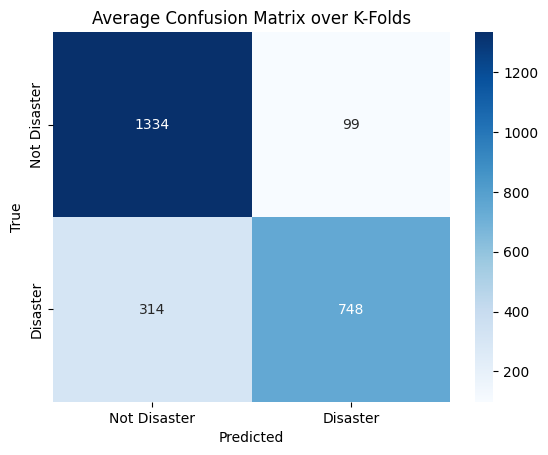

In [40]:
# Display the averaged confusion matrix
def plot_confusion_matrix(cm, title="Confusion Matrix"):
    """
    Plots and saves a confusion matrix using a heatmap.

    Args:
        cm (numpy.ndarray): Confusion matrix to be plotted, typically averaged across K-Folds.
        title (str, optional): Title of the plot. Default is "Confusion Matrix".

    Returns:
        None: Displays and saves the confusion matrix plot as a PNG file.
    """
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues", ax=ax)  # Add fmt=".1f" to format floats
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Not Disaster', 'Disaster'])
    ax.set_yticks([0.5, 1.5])
    ax.set_yticklabels(['Not Disaster', 'Disaster'])

    # Save the plot
    conf_matrix_f = f'conf_matrix_{timestamp}.png'
    plt.savefig(os.path.join(results_dir, conf_matrix_f))

    plt.show()

# Show and save the confusion matrix
plot_confusion_matrix(average_confusion_matrix, title="Average Confusion Matrix over K-Folds")

## Metrics across epochs

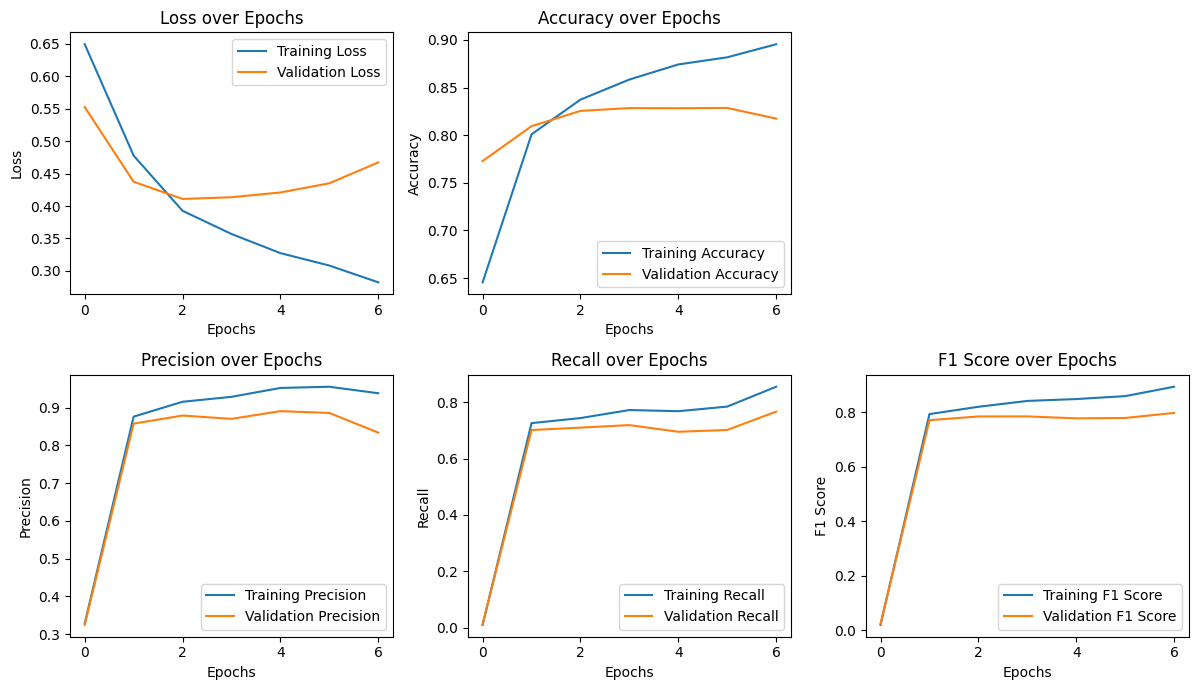

In [41]:
def plot_all_metrics_over_epochs(average_metrics, timestamp):
    """
    Plot training and validation metrics (loss, accuracy, precision, recall, F1 score) over epochs.

    Args:
        average_metrics (dict): Dictionary containing lists of metrics (e.g., 'accuracy', 'val_accuracy').
        timestamp (str): Unique identifier to include in the saved plot filename.

    Saves:
        A PNG file with the plots of all metrics in the specified results directory.
    """
    epochs = [*range(len(average_metrics['accuracy']))]

    plt.figure(figsize=(12, 7))

    # Loss plot
    plt.subplot(2, 3, 1)
    plt.plot(epochs, average_metrics['loss'], label='Training Loss')
    plt.plot(epochs, average_metrics['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(range(0, max(epochs) + 1, 2))  # Adjust x-ticks to display only whole numbers
    plt.legend()

    # Accuracy plot
    plt.subplot(2, 3, 2)
    plt.plot(epochs, average_metrics['accuracy'], label='Training Accuracy')
    plt.plot(epochs, average_metrics['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(range(0, max(epochs) + 1, 2))  # Adjust x-ticks to display only whole numbers
    plt.legend()

    # Precision plot
    plt.subplot(2, 3, 4)
    plt.plot(epochs, average_metrics['precision'], label='Training Precision')
    plt.plot(epochs, average_metrics['val_precision'], label='Validation Precision')
    plt.title('Precision over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.xticks(range(0, max(epochs) + 1, 2))  # Adjust x-ticks to display only whole numbers
    plt.legend()

    # Recall plot
    plt.subplot(2, 3, 5)
    plt.plot(epochs, average_metrics['recall'], label='Training Recall')
    plt.plot(epochs, average_metrics['val_recall'], label='Validation Recall')
    plt.title('Recall over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.xticks(range(0, max(epochs) + 1, 2))  # Adjust x-ticks to display only whole numbers
    plt.legend()

    # F1 plot
    plt.subplot(2, 3, 6)
    plt.plot(epochs, average_metrics['f1'], label='Training F1 Score')
    plt.plot(epochs, average_metrics['val_f1'], label='Validation F1 Score')
    plt.title('F1 Score over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.xticks(range(0, max(epochs) + 1, 2))  # Adjust x-ticks to display only whole numbers
    plt.legend()

    plt.tight_layout()

    # Save the plot with a unique timestamp
    metrics_plots_f = f'metric_plots_{timestamp}.png'

    # Save the plot.
    plt.savefig(os.path.join(results_dir, metrics_plots_f))

    plt.draw()
    plt.show()

# Plot metrics over epochs
plot_all_metrics_over_epochs(average_metrics, timestamp)

# **Gather configs and results from all runs**

To make it easy to see how the hyper-parameter tuning affects the results, we will gather the data from configs_and_results from all runs so far into a single dataframe.

In [42]:
def gather_all_runs():
    """
    Gather and consolidate data from all JSON files in the results directory into a single summary DataFrame.

    Processes:
        - Reads JSON files starting with "config_and_results".
        - Extracts date and time from filenames and appends it to the data.
        - Converts the data into a Pandas DataFrame.
        - Replaces NaNs with empty strings for clean output.
        - Sorts the DataFrame by the date_time column.
        - Saves the consolidated DataFrame to a CSV file.

    Returns:
        pd.DataFrame: A summary DataFrame containing all consolidated run data.
    """
    # List to store each run's data
    all_runs_data = []

    # Loop through each file in the base directory
    for file in os.listdir(results_dir):
        json_file_path = os.path.join(results_dir, file)

        # Only proceed if it's a JSON file that starts with "config_and_results"
        if file.startswith("config_and_results") and file.endswith(".json"):
            # Extract the date and time part from the file name
            date_time_part = file.replace("config_and_results_", "").replace(".json", "")

            # Read the JSON file
            with open(json_file_path, 'r') as json_file:
                config_and_results = json.load(json_file)
                config_and_results['date_time'] = date_time_part  # Add the date and time to the data
                all_runs_data.append(config_and_results)

    # Convert the list of dictionaries into a Pandas DataFrame
    all_runs_summary = pd.DataFrame(all_runs_data)

    # Replace NaNs with empty strings, for pretty output
    all_runs_summary = all_runs_summary.fillna("")

    # Put the date_time column first
    all_runs_summary = all_runs_summary[['date_time'] + [col for col in all_runs_summary.columns if col != 'date_time']]

    # Sort dataframe by data_tiem
    all_runs_summary.sort_values(by = 'date_time', inplace = True)

    # File name for the summary file
    all_runs_summary_f = f'all_runs_summary_{timestamp}.csv'

    # Save the dataframe to a CSV file
    all_runs_summary.to_csv(os.path.join(results_dir, all_runs_summary_f), index = False)

    # Print the table
    all_runs_summary

gather_all_runs()

# **Generate Submission File**

In [43]:
# Test data
X_test = df_test['text']

if config['model'] == 'lstm':
    y_pred_test = model.predict(X_test_padded)
    y_pred_test_binary = (y_pred_test >= 0.5).astype(int)
elif config['model'] == 'distilbert':
    y_pred_test = model.predict(X_test)
    y_pred_test_binary = (y_pred_test[:, 1] >= 0.5).astype(int)

# Get the sample submission file
submission = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))

# Populate the submission file with the results
submission['target'] = y_pred_test_binary

# File name for submission file
submission_f = f'submission_{timestamp}.csv'

# Save the submission file
submission.to_csv(os.path.join(results_dir, submission_f), index = False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step


# **Results and discussion**

The table below shows the model, hyper-parameter settings, and performance metrics for each of the model instances that I built and evaluated.
* Cells highlighted in yellow contain values that were changed from the previous run.
* Blank cells mean that the parameter is not relevant for that model.
* The green cells show the best performance metrics. As we can see, different models performed best on different metrics. Since the Kaggle competition is evaluated on the F1-score, I will use the model with the best F1-score to make predictions for my submission.



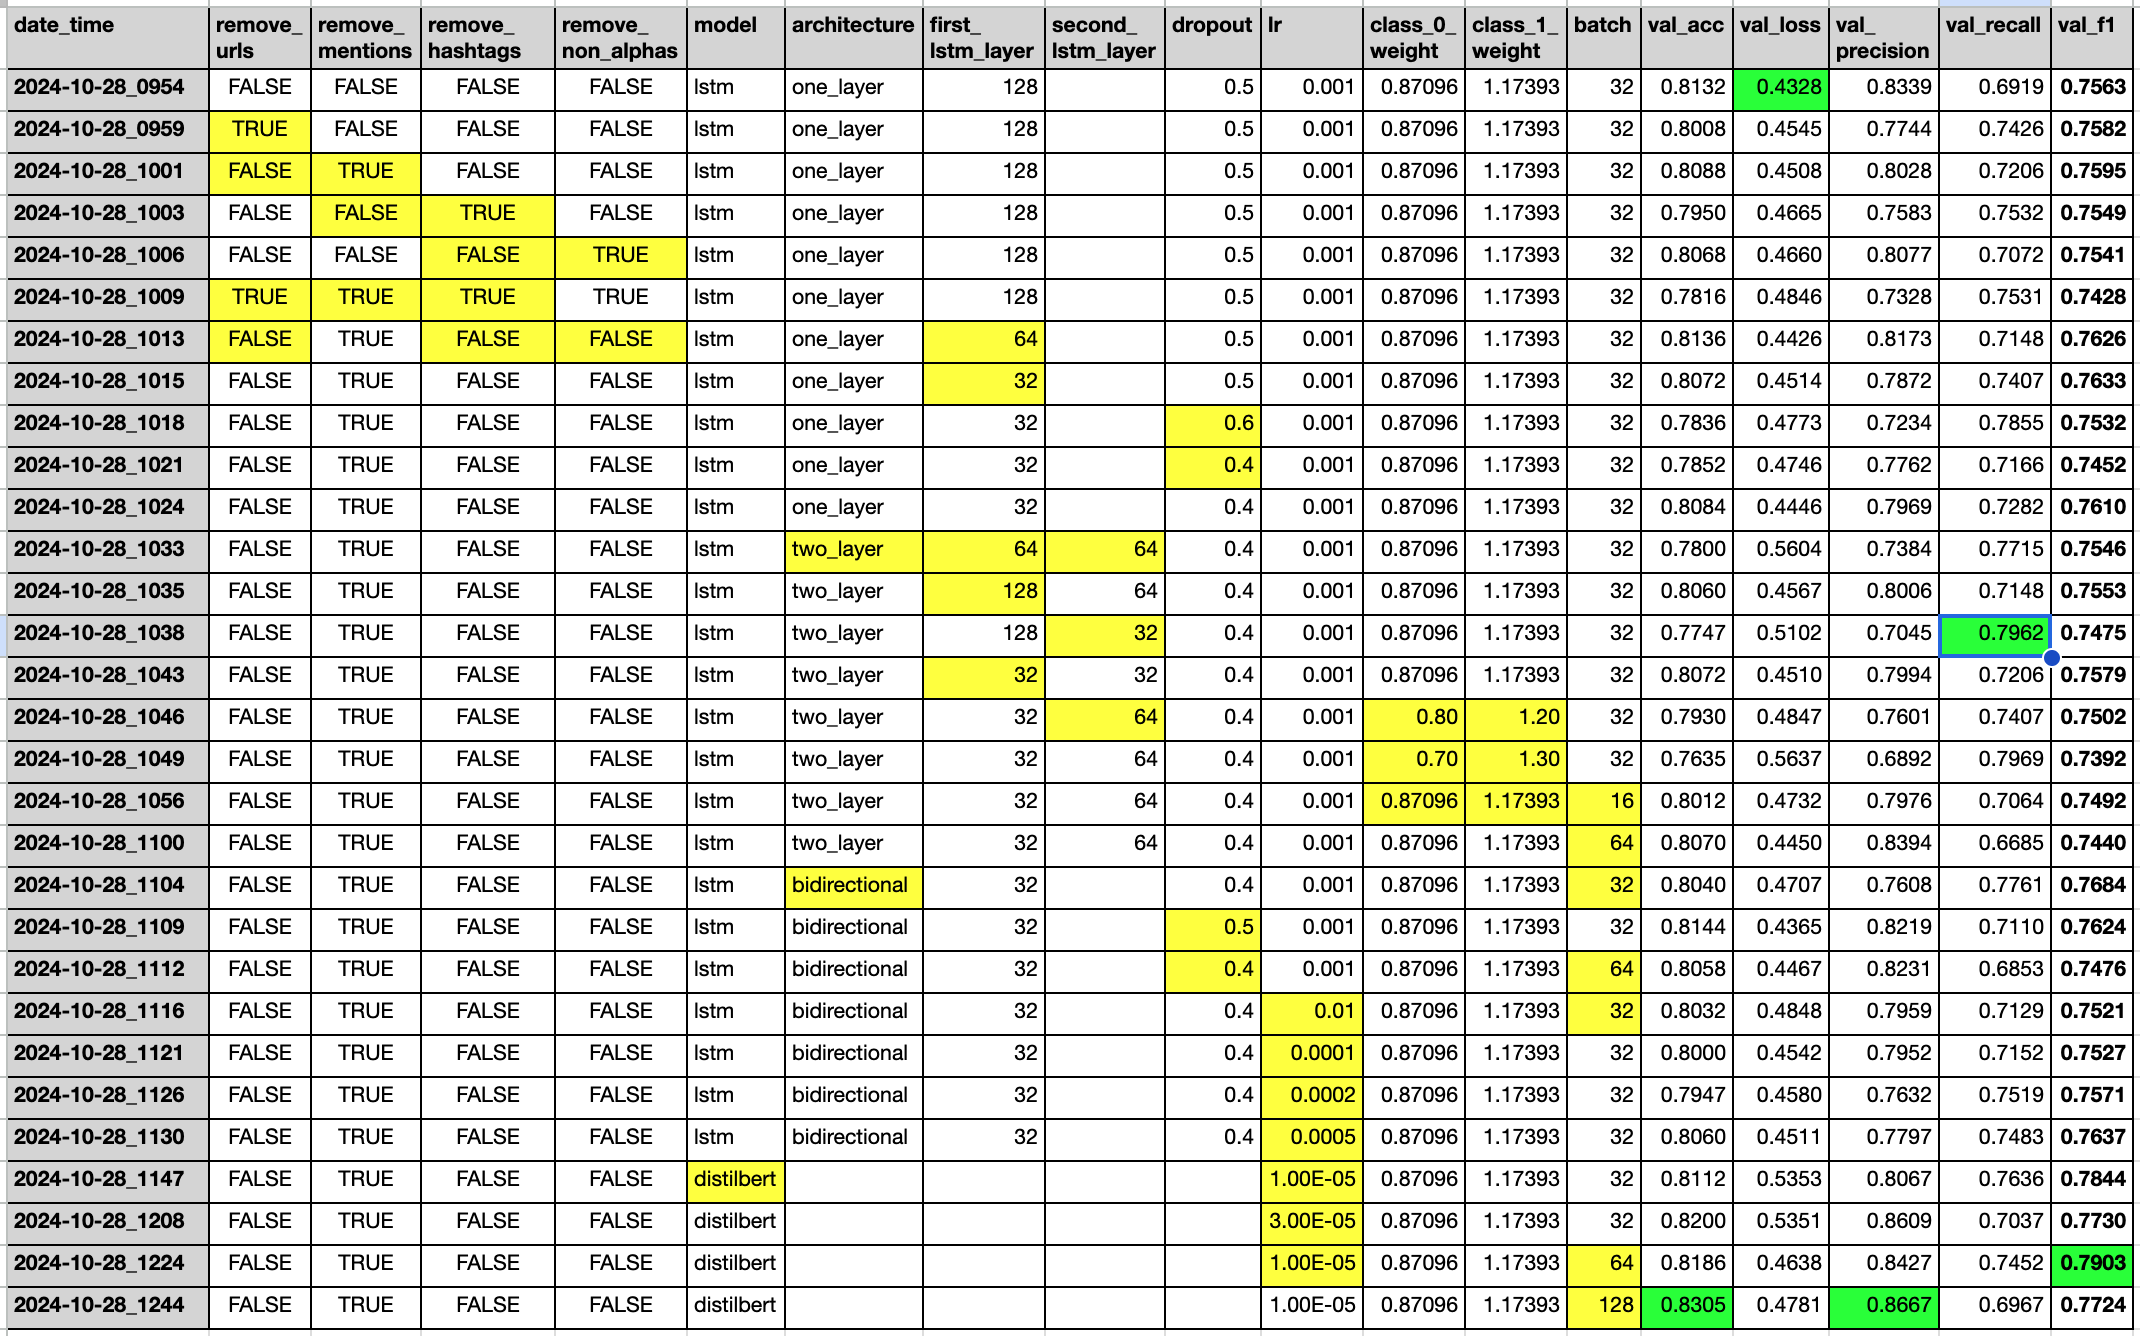

Considering how unreliable I found the labeling of the training set to be, it's hard to imagine how we could achieve a very high accuracy. But I was still surprised at how little improvement I was able to achieve by changing models and tweaking the hyper-parameters. The worst validaton F1-score of any of the models was 0.7392, and the best one 0.7903: a rather modest difference.

The different cleaning options made very little difference. Removing the mentions gave a slightly better validation F1-score than the other cleaning options, but the difference was so small that it might very well have been due to chance.

The DistilBert models tended to have slightly better validation accuracy and F1-score than the LSTM models.

The metrics plots above, which are from the run of the final model I tried, indicate that the model might be overfitting, since the training loss and accuracy continues to improve, while the validation loss gets worse, and the validation accurcy plateaus. The same was true for the model with the best validation F1-score, the second to last model I ran, 2024-10-28_1224.

A model that didn't show that kind of overfitting is model 2024-10-28_1121 (see below), where the validation metrics stay very close to the training metrics. But the validation F1-score of that model was still just 0.7527, significantly worse than I got for model 2024-10-18_1224, in spite of the possible overfitting of that model.


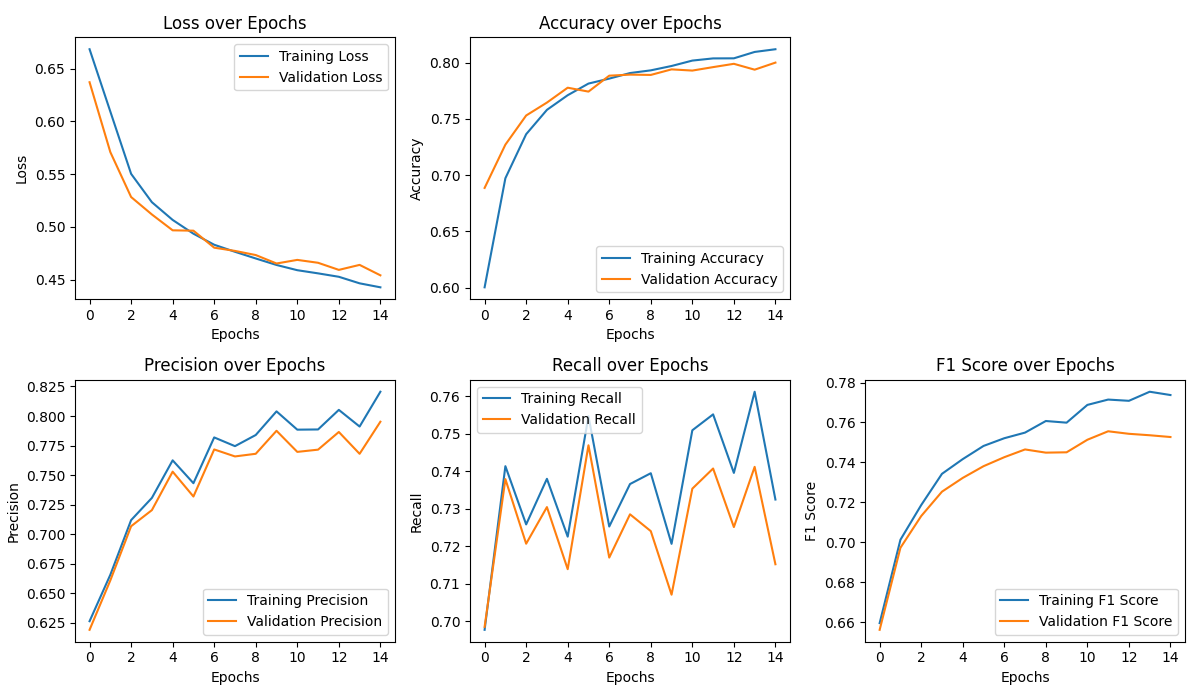

# **Ideas for further work**

**Model architecture**

It would be interesting to explore if a deeper LSTM model, with three or more LSTM layers, might perform better.

**Including keywords**

It's a reasonable hypothesis that the keywords might be indicative of whether a tweet relates to disasters or not, so including them in the training data might be beneficial. This could be done by simply prepending the keywords to the text field.

**Correcting training labels**

Finally, it would be interesting to see if correcting the training labels would lead to better results.